In [2]:
options(warn=-1)
shhh <- suppressPackageStartupMessages # It's a library, so shhh!

shhh(library(glmnet))
shhh(library(tidyverse))
library(gapminder)
library(comprehenr)
library(ggplot2)
library(dplyr)
library(ggpubr)
shhh(library(KernSmooth))

theme_set(theme_bw())
options(warn=0)

### Ejercicio 1

Los datos del fichero *Datos-geyser.txt* corresponden al día de la observación (primera columna), el tiempo medido en minutos (segunda columna $Y$ ) y el tiempo hasta la siguiente erupción (tercera columna $X$) del geyser *Old Faithful* en el parque norteamericano de Yellowstone.

**a)** Representa gráficamente los datos, junto con el estimador de Nadaraya-Watson de la función de regresión de $Y$ sobre $X$.

**b)** Representa gráficamente los datos, junto con el estimador localmente lineal de la función de regresión de $Y$ sobre $X$.

Representaremos ambos estimadores en el mismo gráfico para apreciar mejor las disferencias entre ambos.

In [3]:
geyser_df <- read.table('datos/Datos-geyser.txt', header=TRUE, sep=' ', )
head(geyser_df)

,D,Y,X
,<int>,<int>,<dbl>
1,1,78,4.4
2,1,74,3.9
3,1,68,4.0
4,1,76,4.0
5,1,80,3.5
6,1,84,4.1


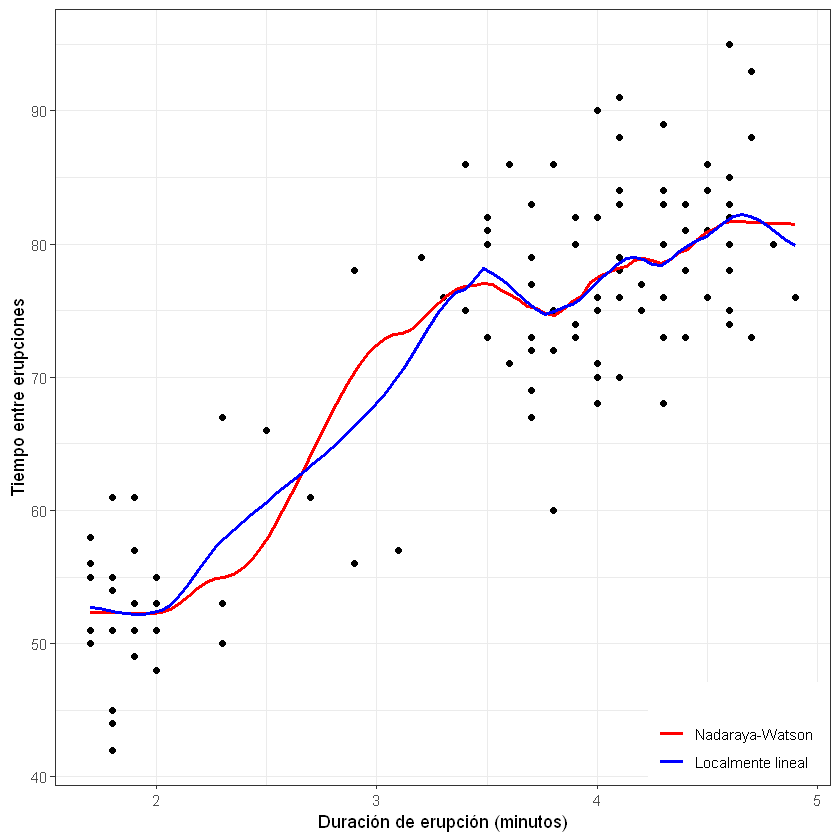

In [4]:
n <- length(geyser_df$X)
loc_lineal <- locpoly(geyser_df$X, geyser_df$Y, degree = 1, gridsize=n,
                      bandwidth = dpill(geyser_df$X, geyser_df$Y))

ggplot(geyser_df, aes(X, Y)) +
  geom_point() +
  geom_smooth(formula=y~x, method = 'loess', se = FALSE, span = 0.25, method.args = list(degree=0), aes(col='Nadaraya-Watson')) +
  geom_smooth(formula=y~x, method = 'loess', se = FALSE, span = 0.25, method.args = list(degree=1), aes(col='Localmente lineal')) +
  scale_colour_manual("", breaks = c('Nadaraya-Watson', 'Localmente lineal'), values = c('red', 'blue')) +
  labs(x = 'Duración de erupción (minutos)', y = 'Tiempo entre erupciones') +
  theme(legend.justification=c(1,0), legend.position=c(1,0))

### Ejercicio 4

Se considera el siguiente modelo de regresión lineal múltiple:

$$
\begin{equation} \label{eq:model} \tag{1}
    Y_i = \beta_0 + \beta_1 x_{i1} + \beta_2 x_{i2} + \beta_3 x_{i3} + \epsilon_i, \quad \epsilon_i \sim N(0, \sigma^2), \quad i\in\{1,\ldots,n\}
\end{equation}
$$

Se dispone de $n=20$ observaciones con las que se ajustan todos los posibles submodelos del modelo \eqref{model}, obteniéndose para cada uno de ellos las siguientes sumas de cuadrados de los residuos (todos los submodelos incluyen un término independiente):

| Variables incluidas en el modelo |          Coeficientes de regresión          |    SCR   |
|:--------------------------------:|:-------------------------------------------:|:--------:|
|    Sólo término independiente    |                  $\beta_0$                  | 42644.00 |
|               $x_1$              |            $\beta_0$ y $\beta_1$            |  8352.28 |
|               $x_2$              |            $\beta_0$ y $\beta_2$            | 36253.69 |
|               $x_3$              |            $\beta_0$ y $\beta_3$            | 36606.19 |
|           $x_1$ y $x_2$          |       $\beta_0$, $\beta_1$ y $\beta_2$      |  7713.13 |
|           $x_1$ y $x_3$          |       $\beta_0$, $\beta_1$ y $\beta_3$      |  762.55  |
|           $x_2$ y $x_3$          |       $\beta_0$, $\beta_2$ y $\beta_3$      | 32700.17 |
|       $x_1$, $x_2$ y $x_3$       | $\beta_0$, $\beta_1$, $\beta_2$ y $\beta_3$ |  761.41  |


**a)** Calcula la tabla de análisis de la varianza para el modelo \eqref{eq:model} y contrasta a nivel $\alpha = 0,05$ la hipótesis nula $H_0: \beta_1 = \beta_2 = \beta_3 = 0$.

**ab)** En el modelo \eqref{eq:model} , contrasta a nivel $\alpha = 0,05$ las dos hipótesis nulas siguientes:

- $H_0: \beta_2 = 0$
- $H_0: \beta_1 = \beta_3 = 0$

In [5]:
n <- 20
p <- 3
all_scrs <- c(42644, 8352.28, 36253.69, 36606.19, 7713.13, 762.55, 32700.17, 761.41)
scr <- all_scrs[8]
sce <- all_scrs[1] - scr

source <- c("Complete model", "Residuals")
df <- c(p, n - p - 1)
sum_sq <- c(sce, scr)
mean_sq <- sum_sq/df
f <- c(mean_sq[1]/mean_sq[2], NA)
pr_f <- c(pf(f[1], df1=p, df2=n-p-1, lower.tail=FALSE), NA)

variance_table <- data.frame(Source=source, Df=df, Sum_Sq=sum_sq, Mean_Sq=mean_sq, F_value=f, p_value=pr_f)
variance_table

Source,Df,Sum_Sq,Mean_Sq,F_value,p_value
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Complete model,3,41882.59,13960.86333,293.3686,3.421043e-14
Residuals,16,761.41,47.58812,NA,NA


**b) Caso $H_0: \beta_2=0$.**

In [6]:
reduced_model_p_value <- function(total_scr, reduced_scr, n, p, k) {
    numerator <- (reduced_scr - total_scr) / k
    denominator <- total_scr / (n - p - 1)
    pf(numerator/denominator, df1=k, df2=n-p-1, lower.tail=FALSE)
}

k <- 1
print(paste('p-value: ', reduced_model_p_value(all_scrs[8], all_scrs[3], n, p, k)))

[1] "p-value:  7.50451101383861e-15"


Puesto que obtenemos un *p-value* de $\approx 7.5 \cdot 10^{-15} < 0.05$, rechazamos la hipótesis nula. Es decir, **la variable $x_2$ si es significativa para la predicción de $y$**.

**b) Caso $H_0: \beta_1 = \beta_3 = 0$.**

In [7]:
k <- 2
print(paste('p-value: ',
            reduced_model_p_value(all_scrs[8], all_scrs[6], n, p, k)))

[1] "p-value:  0.988102521110228"


Puesto que obtenemos un *p-value* de $\approx 0.99 > 0.05$, no hay suficiente evidencia para rechazar la hipótesis nula. Es decir, **las variable $x_1$ y $x_3$ no son significativas para la predicción de $y$**.

### Ejercicio 6

Sean $Y_1$, $Y_2$ e $Y_3$ tres variables aleatorias independientes con distribución normal y varianza $\sigma^2$. Supongamos que $\mu$ es la media de $Y_1$, $\lambda$ es la media de $Y_2$ y $\lambda + \mu$ es la media de $Y_3$, donde $\lambda, mu \in \mathbb R$.

**a)** Demuestra que el vector $Y = (Y_1, Y_2, Y_3)'$0 verifica el modelo de regresión múltiple $Y = X\beta + \epsilon$. Para ello, determina la matriz de diseño $X$, el vector de parámetros $\beta$ y la distribución de las variables de error $\epsilon$.

Podemos expresar el vector de variables independientes de la siguiente forma:

$$\begin{pmatrix}
    Y_1 \\
    Y_2 \\
    Y_3 \\
\end{pmatrix} =
\underbrace{ \begin{pmatrix}
    1 & 0 \\
    0 & 1 \\
    1 & 1
\end{pmatrix} }_{X}
\underbrace{ \begin{pmatrix}
    \mu \\
    \lambda
\end{pmatrix} }_{\beta} +
\begin{pmatrix}
    \epsilon_1 \\
    \epsilon_2 \\
    \epsilon_3
\end{pmatrix} \quad
\epsilon_i \sim N(0, \sigma^2)
$$

Obteniendo el siguiente modelo de regresión múltiple:

$$
   Y \sim N(X\beta, \sigma^2 I)
$$

**b)** Calcula los estimadores de máxima verosimilitud (equivalentemente, de mínimos cuadrados) de $\lambda$ y $\mu$.

Sabemos que el estimador de mínimos cuadrados puede calcular utilizando la siguiente expresión:

$$
    \hat \beta = (X'X)^{-1}X'Y
$$

Sin embargo, para demostrar esta expresión en clase nos basamos en que la matriz de diseño tenía una columna de unos (el modelo tenía un término independiente $\beta_0$). ¿Es ésta expresión cierta si el modelo carece de término independiente?

La respuesta es afirmativa. Para obtenerla sin hacer uso de dicha hipótesis podemos simplemente obtener el valor que minimiza el error cuadrado mínimo derivando e igualando a $0$ en la siguiente expresión:

$$
    L(\sigma, \beta) = \; \parallel Y - X\beta \;\parallel^2_2
$$

Las cuentas no son complicadas, puede consultarse la demostración completa en [Wikipedia](https://en.wikipedia.org/wiki/Least_squares#Linear_least_squares). Calculemos estos valores para nuestro caso particular:

$$
X'X =
\begin{pmatrix}
    1 & 0 & 1 \\
    0 & 1 & 1 \\
\end{pmatrix}
\begin{pmatrix}
    1 & 0 \\
    0 & 1 \\
    1 & 1
\end{pmatrix} = 
\begin{pmatrix}
    2 & 1 \\
    1 & 2
\end{pmatrix}
$$

$$
(X'X)^{-1} = \frac{1}{3}
\begin{pmatrix}
    2 & -1 \\
    -1 & 2
\end{pmatrix}
$$

$$
(X'X)^{-1}X' = \frac{1}{3}
\begin{pmatrix}
    2 & -1 \\
    -1 & 2
\end{pmatrix}
\begin{pmatrix}
    1 & 0 & 1 \\
    0 & 1 & 1 \\
\end{pmatrix} = \frac{1}{3}
\begin{pmatrix}
    2 & -1 & 1 \\
    -1 & 2 & 1 \\
\end{pmatrix}
$$

$$
\hat \beta = (X'X)^{-1}X'Y =
\begin{pmatrix}
    2 & -1 & 1 \\
    -1 & 2 & 1 \\
\end{pmatrix}
\begin{pmatrix}
    Y_1 \\
    Y_2 \\
    Y_3 \\
\end{pmatrix} = \frac{1}{3}
\begin{pmatrix}
    2 Y_1 - Y_2 + Y_3 \\
    -Y_1 + 2 Y_2 + Y_3
\end{pmatrix}
$$


**c)** Calcula la distribución del vector $(\hat \lambda, \hat \mu)'$, formado por los estimadores calculados en el apartado anterior.

Puesto que el vector de variables independientes cumple

$$
   Y \sim N(X\beta, \sigma^2 I)
$$

Y sabiendo que $\hat \beta = (X'X)^{-1}X'Y$, obtenemos que $\hat \beta$ sigue una distribución normal multivariante:

$$
   \hat \beta \sim N( ((X'X)^{-1}X') \cdot X\beta, ((X'X)^{-1}X') \cdot \sigma^2 I \cdot ((X'X)^{-1}X')')
$$

Para la esperanza:

$$
    \mathbb E [\hat\beta] = (X'X)^{-1}X' \cdot X\beta = (X'X)^{-1} \cdot (X'X) \beta = \beta
$$

Luego el estimador es insesgado. Por otro lado, para la varianza hemos de ver que $X'X$ es simétrica (y por lo tanto su inversa también lo será):

$$
    (X'X)' = X'X'' = X'X
$$

Por lo tanto, la varianza cumple:

$$
\begin{align}
    \text{Var}[\hat\beta] & = ((X'X)^{-1}X') \cdot \sigma^2 I \cdot ((X'X)^{-1}X')' \\
     & = \sigma^2 (X'X)^{-1} (X'X) (X'X)^{-1} \\
     & = \sigma^2 (X'X)^{-1} \\
\end{align}
$$

Obtenemos así la expresión reducida de la distribución que siguen los estimadores:

$$
   \hat \beta \sim N( \beta, \sigma^2(X'X)^{-1})
$$

### Ejercicio 10

Los datos *fuel2001* del fichero *combustible.RData* corresponden al consumo de combustible (y otras variables relacionadas) en los estados de EE.UU.
Se desea explicar la variable ***FuelC*** en función del resto de la información.

In [8]:
datos <- 'http://verso.mat.uam.es/~joser.berrendero/datos/combustible.RData'
load(url(datos))
head(fuel2001)

,Drivers,FuelC,Income,Miles,MPC,Pop,Tax
,<int>,<int>,<int>,<int>,<dbl>,<int>,<dbl>
AL,3559897,2382507,23471,94440,12737.00,3451586,18.0
AK,472211,235400,30064,13628,7639.16,457728,8.0
AZ,3550367,2428430,25578,55245,9411.55,3907526,18.0
AR,1961883,1358174,22257,98132,11268.40,2072622,21.7
CA,21623793,14691753,32275,168771,8923.89,25599275,18.0
CO,3287922,2048664,32949,85854,9722.73,3322455,22.0


**a)** Representa en un plano las dos primeras componentes principales de estos datos estandarizados (consulta la ayuda de *prcomp*). ¿Son suficientes estas dos componentes para explicar un alto porcentaje de la varianza?

En primer lugar, hemos de aclarar que como nuestro objetivo final es predecir la variable *FuelC*, la quitamos de nuestro conjunto de datos para hacer PCA. Si la mantuviésemos, las componentes principales no se podrían utilizar para predecir dicha variable ya que ya la contienen. Si simplemente quisiésemos realizar una análisis de PCA sobre los datos para hacer, por ejemplo, cluestering, mantendríamos dicha variable. He tomado esta decisión porque en el enunciado no aclara que debamos quitarlo, pero tiene sentido para nuestra aplicación final.

Utilizamos la función de R *prcomp* sugerida en el enunciado con los parámetros *center* y *scale.* para normalizar las variables antes de computar el análisos. Pintamos a continuación las dos primeras componentes principales:

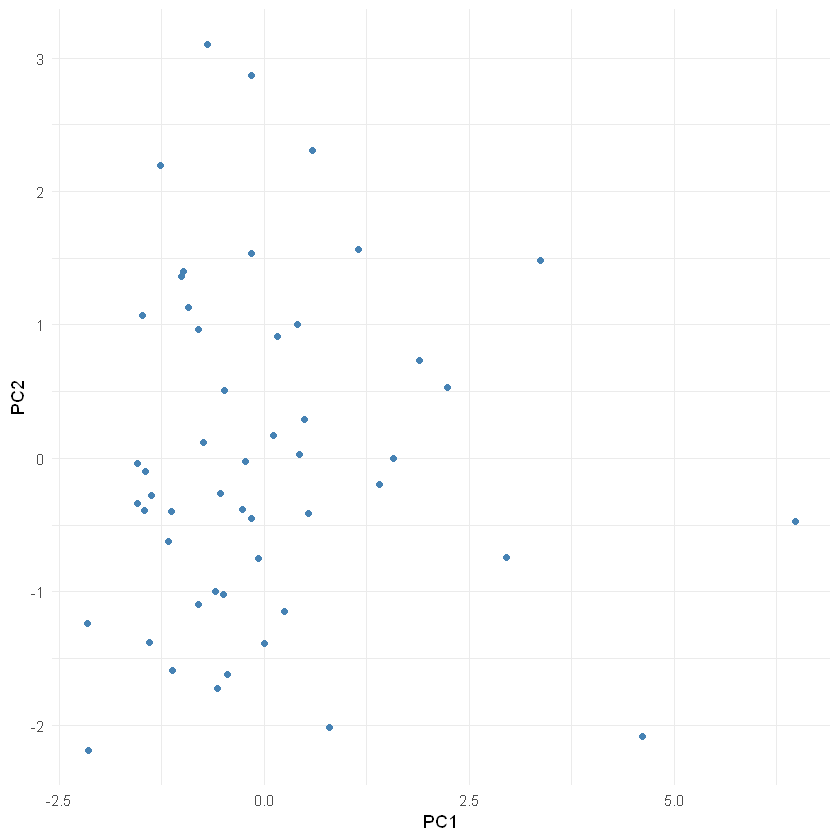

In [9]:
fuel2001_without_FuelC <- data.frame(fuel2001)
fuel2001_without_FuelC$FuelC <- NULL
pca <- prcomp(fuel2001_without_FuelC, center=TRUE, scale.=TRUE)

ggplot(as.data.frame(pca$x), aes(PC1, PC2)) +
    geom_point(color="steelblue") +
    labs(x='PC1', y='PC2') +
    theme_minimal()

Como se aprecia en el gráfico, los puntos están relativamente separados. Este es el objetivo principal de PCA: maximizar la distancia entre puntos (la varianza) utilizando un conjunto mínimo de variables, siendo éstas combinaciones lineales de las orginales. Utilizamos *summary* para ver los resultados numéricos del PCA.

Importance of components:
                          PC1    PC2    PC3     PC4     PC5     PC6
Standard deviation     1.6518 1.2593 0.9968 0.63696 0.53093 0.06854
Proportion of Variance 0.4547 0.2643 0.1656 0.06762 0.04698 0.00078
Cumulative Proportion  0.4547 0.7190 0.8846 0.95224 0.99922 1.00000

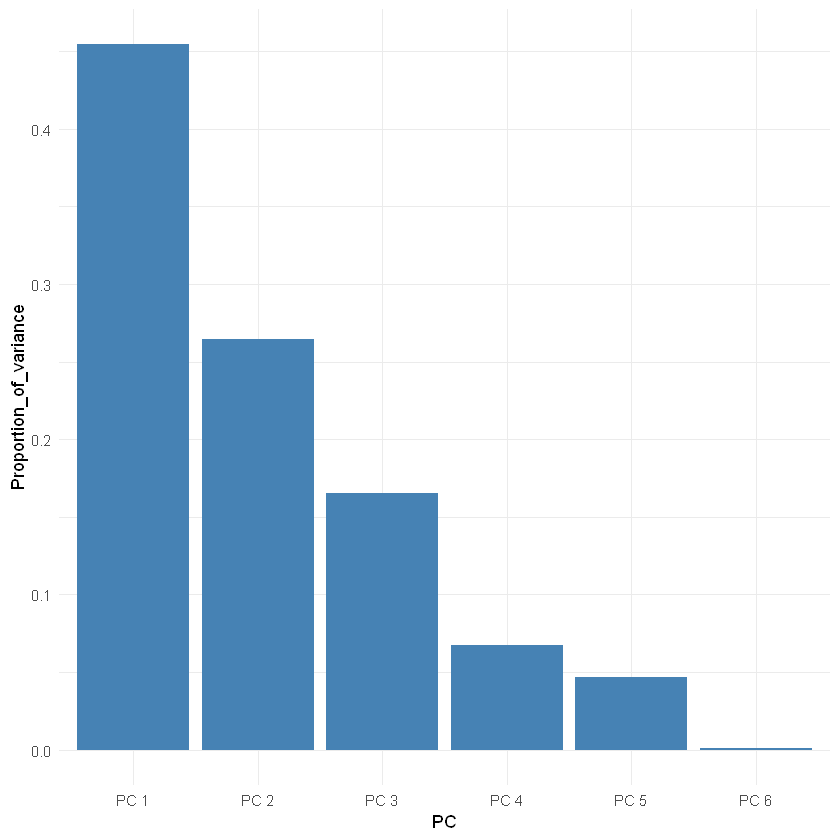

In [10]:
summary(pca)

pov <- summary(pca)$importance[2,]
names <- c(paste('PC', 1:6))
proportions_df <- data.frame(PC=names, Proportion_of_variance=pov)

ggplot(proportions_df, aes(x=PC, y=Proportion_of_variance)) +
    geom_bar(stat="identity", fill="steelblue") +
    theme_minimal()

Obtenemos así un $71.90\%$ de varianza explicada utilizando únicamente 2 componentes principales.

Si repetimos este análisis añadiendo la variable *FuelC* obtenemos 7 componentes principales en vez de 6, y la dos primeras explican un $75.47\%$ de la varianza.

**b)** Ajusta el modelo completo con todas las variables. En este modelo completo, contrasta la hipótesis nula de que los coeficientes de las variables **Income**, **MPC** y **Tax** son simultáneamente iguales a cero.

Como vimos en el ejercicio 4, para comprobar este tipo de hipótesis hemos de ajustar ambnos modelos (completo y reducido), y utilizar el siguiente estadístico:

$$
    F = \frac{ (SCR_0 - SCR) / k }{ SCR / (n - p - 1) }
$$

Nuestro *p-value* será:

$$
    \mathbb P [F_{k;n-p-1} \ge F]
$$

In [11]:
complete_model <- lm(FuelC ~ ., data=fuel2001)
summary(complete_model)


Call:
lm(formula = FuelC ~ ., data = fuel2001)

Residuals:
     Min       1Q   Median       3Q      Max 
-1480910  -158802    19267   174208  1090089 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) -4.902e+05  8.199e+05  -0.598 0.552983    
Drivers      6.368e-01  1.452e-01   4.386 7.09e-05 ***
Income       7.690e+00  1.632e+01   0.471 0.639793    
Miles        5.850e+00  1.621e+00   3.608 0.000784 ***
MPC          4.562e+01  3.565e+01   1.280 0.207337    
Pop         -1.945e-02  1.245e-01  -0.156 0.876586    
Tax         -2.087e+04  1.324e+04  -1.576 0.122235    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 398400 on 44 degrees of freedom
Multiple R-squared:  0.9808,	Adjusted R-squared:  0.9782 
F-statistic: 374.6 on 6 and 44 DF,  p-value: < 2.2e-16


In [12]:
reduced_model <- lm(FuelC ~ Drivers + Miles + Pop, data=fuel2001)
summary(reduced_model)


Call:
lm(formula = FuelC ~ Drivers + Miles + Pop, data = fuel2001)

Residuals:
     Min       1Q   Median       3Q      Max 
-1486667  -209534    25497   186536  1083358 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) -2.374e+05  1.047e+05  -2.268 0.027964 *  
Drivers      7.156e-01  1.446e-01   4.949 9.98e-06 ***
Miles        6.125e+00  1.472e+00   4.161 0.000134 ***
Pop         -8.879e-02  1.229e-01  -0.722 0.473593    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 408800 on 47 degrees of freedom
Multiple R-squared:  0.9784,	Adjusted R-squared:  0.977 
F-statistic: 709.9 on 3 and 47 DF,  p-value: < 2.2e-16


In [13]:
scr_complete <- summary(complete_model)$sigma
scr_reduced <- summary(reduced_model)$sigma
n <- nrow(fuel2001)
p <- 6
k <- 3

print(paste('p-value: ', reduced_model_p_value(scr_complete, scr_reduced, n, p, k)))

anova(complete_model, reduced_model)

[1] "p-value:  0.765503347571403"


,Res.Df,RSS,Df,Sum of Sq,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,44,6.984313e+12,NA,NA,NA,NA
2,47,7.855597e+12,-3,-871284719267,1.829649,0.1556908


Puesto que obtenemos un *p-value* de $0.1557 \gg 0.05$, no tenemos evidentas suficientes para rechazar la hipótesis nula.

**c)** De acuerdo con el método iterativo hacia adelante y el criterio BIC, ¿cúal es el modelo óptimo?

Subset selection object
Call: regsubsets.formula(FuelC ~ ., data = fuel2001, method = "forward")
6 Variables  (and intercept)
        Forced in Forced out
Drivers     FALSE      FALSE
Income      FALSE      FALSE
Miles       FALSE      FALSE
MPC         FALSE      FALSE
Pop         FALSE      FALSE
Tax         FALSE      FALSE
1 subsets of each size up to 6
Selection Algorithm: forward
         Drivers Income Miles MPC Pop Tax
1  ( 1 ) "*"     " "    " "   " " " " " "
2  ( 1 ) "*"     " "    "*"   " " " " " "
3  ( 1 ) "*"     " "    "*"   " " " " "*"
4  ( 1 ) "*"     " "    "*"   "*" " " "*"
5  ( 1 ) "*"     "*"    "*"   "*" " " "*"
6  ( 1 ) "*"     "*"    "*"   "*" "*" "*"

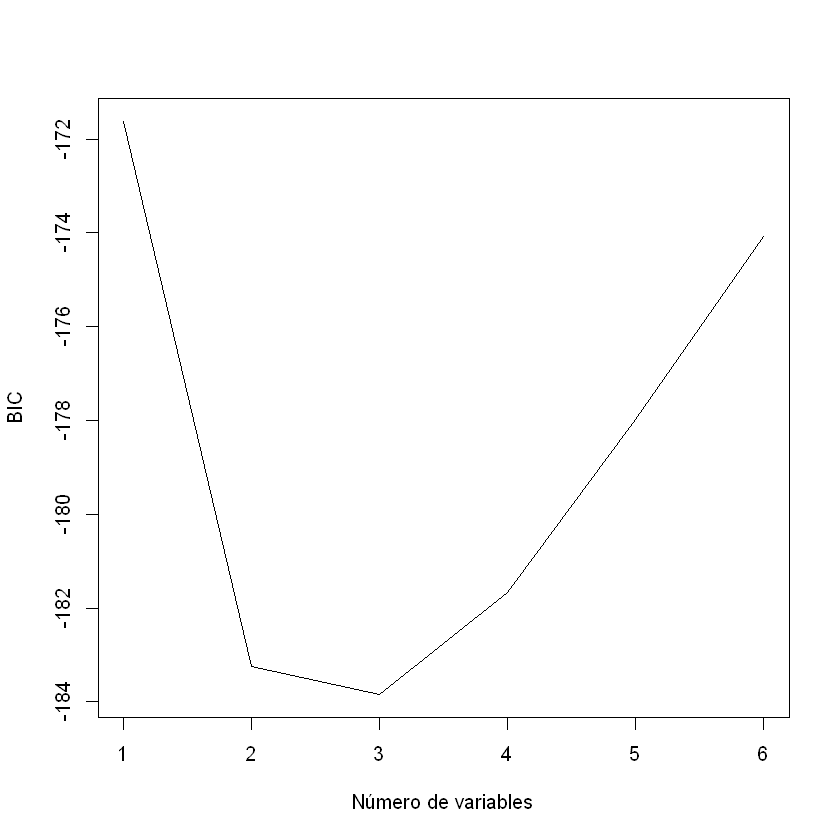

In [14]:
iterative_model <- leaps::regsubsets(FuelC ~ ., data=fuel2001, method='forward')

summary(iterative_model)
plot(summary(iterative_model)$bic,
     xlab="Número de variables", 
     ylab="BIC", type="l")

El modelo que minimiza el criterio BIC es aquel con tres variables. Como podemos ver en el resumen, el mejor modelo con variables en el método iterativo es aquel que utiliza unicamente ***Drivers***, ***Miles*** y ***Tax***.

**d)** Ajusta el modelo usando lasso, con el parámetro de regularización seleccionado mediante validación cruzada.

In [60]:
set.seed(123)
x <- as.matrix(fuel2001_without_FuelC)
y <- fuel2001$FuelC
lasso_model_cv <- cv.glmnet(x, y, alpha=1) # alpha=1 es lasso
lasso_model_cv


Call:  cv.glmnet(x = x, y = y, alpha = 1) 

Measure: Mean-Squared Error 

    Lambda Index   Measure        SE Nonzero
min  15772    56 3.307e+11 1.484e+11       4
1se 234210    27 4.655e+11 1.998e+11       2

Vemos así los valores de $\lambda$ obtenidos en validación cruzada, donde *Measure* es la desviación típica, el valor por defecto.

El $\lambda_{min}$ es aquel valor de $\lambda$ que minimiza la media del error en validación cruzada. El $\lambda_{1se}$ es tal que el error esta a una desviación típica del error. Utilizaremos $\lambda_{min}$ ya que minimiza el error a pesar de ser más restrictivo (introducir más sesgo).

Merece la pena destacar que hemos fijado la semilla. Al aplicar validación cruzada obteníamos valores muy variables para ambos lambdas, de esta forma los resultados son completamente reproducibles.

In [62]:
lambda_lasso <- lasso_model_cv$lambda.min
final_lasso_model <- glmnet(x, y, alpha=1, lambda=lambda_lasso) # alpha=1 es lasso
coef(final_lasso_model)

7 x 1 sparse Matrix of class "dgCMatrix"
                       s0
(Intercept) -1.048244e+05
Drivers      6.132198e-01
Income       .           
Miles        5.525452e+00
MPC          2.987686e+01
Pop          .           
Tax         -1.945966e+04

Como podemos ver, ajustado lasso de esta forma mantenemos las variables ***Drivers***, ***Miles***, ***MPC*** y ***Tax***.

**e)** Ajusta el modelo usando **ridge**, con el parámetro de regularización seleccionado mediante validación cruzada.

In [63]:
set.seed(123)
ridge_model_cv <- cv.glmnet(x, y, alpha=0) # alpha=0 es ridge
ridge_model_cv


Call:  cv.glmnet(x = x, y = y, alpha = 0) 

Measure: Mean-Squared Error 

    Lambda Index   Measure        SE Nonzero
min 263094   100 2.909e+11 1.179e+11       6
1se 732075    89 4.033e+11 1.869e+11       6

In [64]:
lambda_ridge <- lasso_model_cv$lambda.min
final_ridge_model <- glmnet(x, y, alpha=0, lambda=lambda_ridge) # alpha=0 es ridge
coef(final_ridge_model)

7 x 1 sparse Matrix of class "dgCMatrix"
                       s0
(Intercept) -4.336052e+05
Drivers      4.627274e-01
Income       7.555968e+00
Miles        5.861386e+00
MPC          4.889985e+01
Pop          1.265333e-01
Tax         -2.366901e+04

Obtenemos un valor de $\lambda_{min}$ mucho mayor: $263094$ en vez de $15772$. El modelo final es mucho menos restrictivo, manteniendo todas las variables.